Dados do Sensor:


,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31


Dados da Estação:


,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0
2,2020-09-01,02:00:00,0.0
3,2020-09-01,03:00:00,0.0
4,2020-09-01,04:00:00,0.0


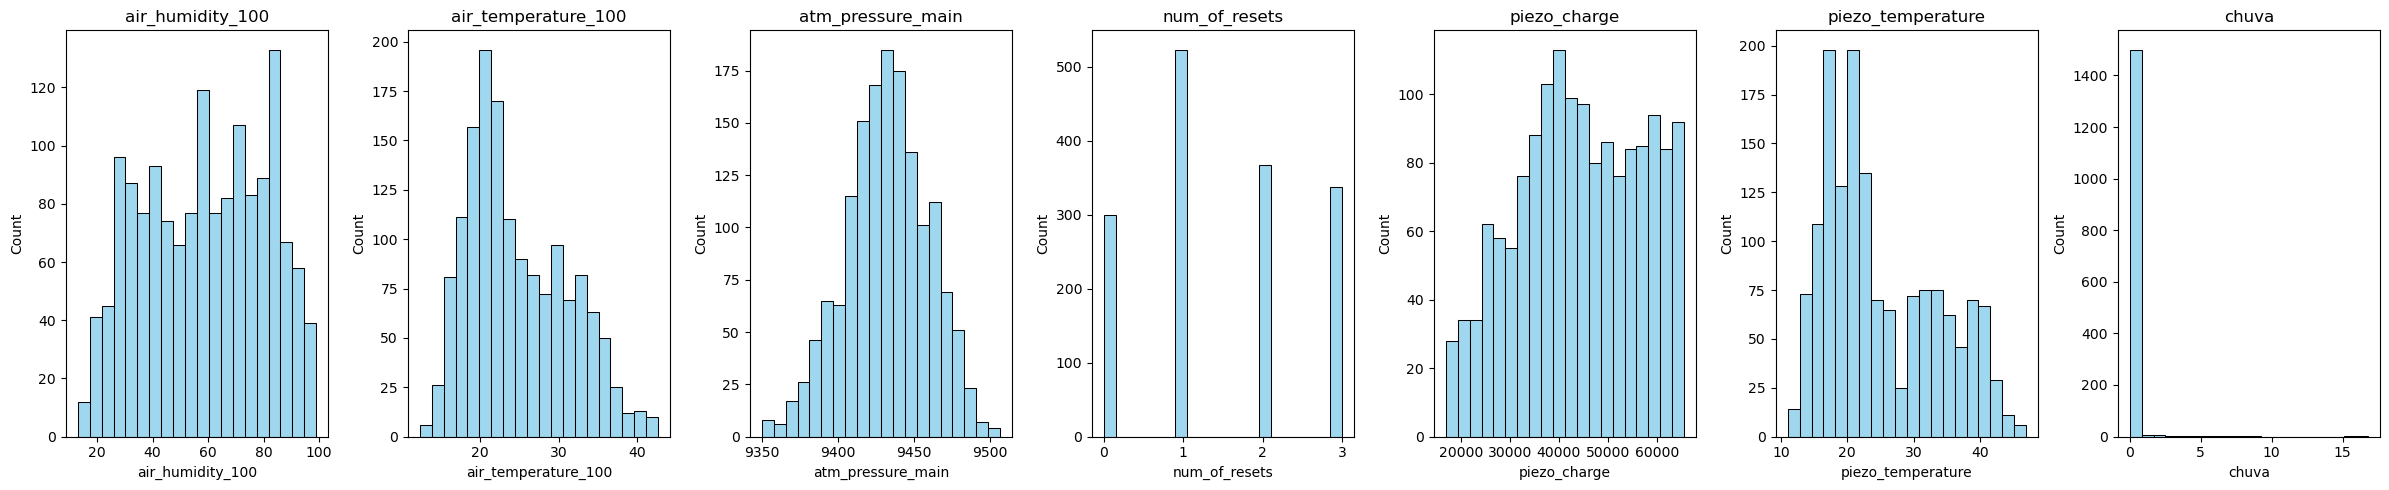

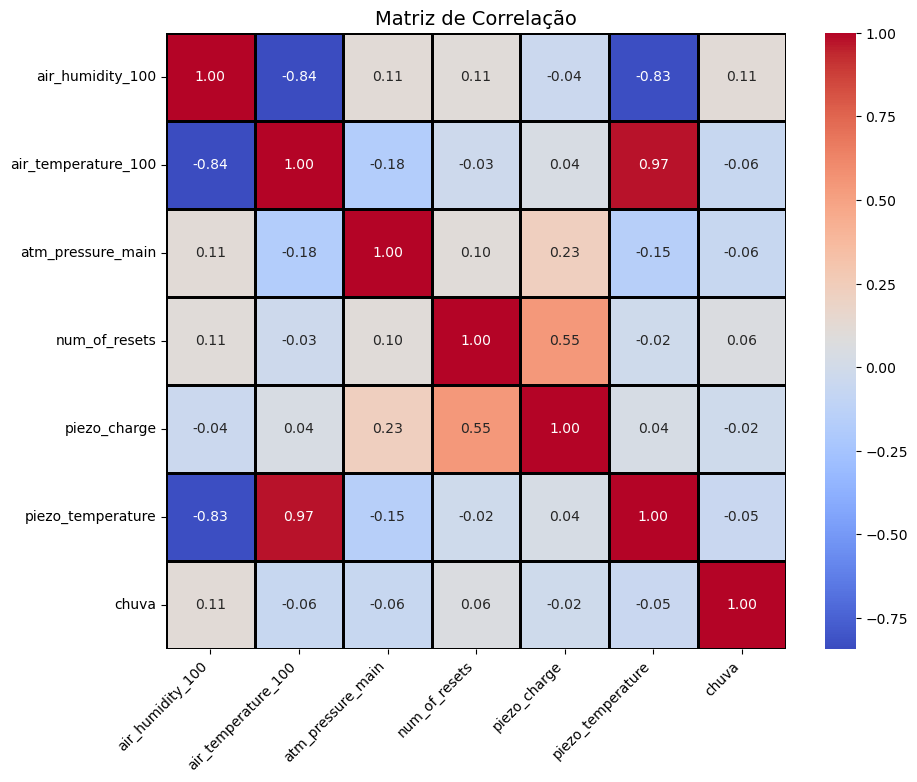

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [ ]:
from flask import Flask, render_template
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import warnings
warnings.filterwarnings("ignore")

app = Flask(__name__)

@app.route('/')
def index():
    return 'Bem-vindo ao meu aplicativo Flask no Heroku!'

def load_data():
    # Etapa 1: Carregamento dos dados
    df_sensor = pd.read_csv('/Users/batistajunior/Heroku/Sensor_FieldPRO.csv')
    df_estacao = pd.read_csv('/Users/batistajunior/Heroku/Estacao_Convencional.csv')

    # Etapa 2: Verificação dos dados
    print("Dados do Sensor:")
    display(df_sensor.head())
    print("Dados da Estação:")
    display(df_estacao.head())

    # Etapa 3: Pré-processamento dos dados
    df_sensor['Datetime – utc'] = pd.to_datetime(df_sensor['Datetime – utc'], utc=True)
    df_sensor['data'] = df_sensor['Datetime – utc'].dt.date
    df_sensor['Hora (Brasília)'] = df_sensor['Datetime – utc'].dt.time
    df_sensor = df_sensor.drop(columns=['Datetime – utc'])

    # Reordenando as colunas com 'data' e 'Hora (Brasília)' na frente
    df_sensor = df_sensor[['data', 'Hora (Brasília)', 'air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 'piezo_charge', 'piezo_temperature']]

    # Convertendo as colunas 'data' e 'Hora (Brasília)' para o tipo datetime no DataFrame df_estacao
    df_estacao['data'] = pd.to_datetime(df_estacao['data'])
    df_estacao['Hora (Brasília)'] = pd.to_datetime(df_estacao['Hora (Brasília)'], format='%H:%M:%S', errors='coerce').dt.time

    # Juntando os DataFrames df_sensor e df_estacao com base nas colunas 'data' e 'Hora (Brasília)'
    df_completo = pd.concat([df_sensor.set_index(['data', 'Hora (Brasília)']), df_estacao.set_index(['data', 'Hora (Brasília)'])], axis=1, join='inner').reset_index()

    # Etapa 4: Análise exploratória dos dados e visualização de gráficos
    # Verificando quais colunas têm dados válidos para plotar os gráficos
    valid_columns = ['air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 'piezo_charge', 'piezo_temperature', 'chuva']

    # Verificando se há alguma coluna com dados válidos para plotar os gráficos
    if all(df_completo[col].notnull().any() for col in valid_columns):
        # Visualizando a distribuição das variáveis e plotando os gráficos
        fig, axes = plt.subplots(1, 7, figsize=(24, 5))
        for i, col in enumerate(valid_columns):
            sns.histplot(df_completo[col], bins=20, edgecolor='black', color='skyblue', alpha=0.8, ax=axes[i])
            axes[i].set_title(col)
        plt.tight_layout()
        plt.show()

        # Verificando a correlação entre as variáveis numéricas
        correlation_matrix = df_completo[valid_columns].corr()

        # Plotando a matriz de correlação
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, linecolor='black', annot_kws={"size": 10})
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.title('Matriz de Correlação', fontsize=14)
        plt.show()

    return df_completo

@app.route('/analise')
def analise():
    # Etapa 1: Carregamento dos dados
    df_completo = load_data()

    # Exemplo de visualização do DataFrame df_completo:
    return df_completo.head().to_html()

@app.route('/treinamento')
def treinamento():
    # Etapa 5: Preparação dos dados para treinamento do modelo
    # Definindo as features e o target
    features = ['air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 'piezo_charge', 'piezo_temperature']
    target = 'chuva'

    # Resto do código para o treinamento do modelo...

    return f"Erro Médio Absoluto (MAE): {mae}<br>Erro Quadrático Médio (MSE): {mse}<br>Coeficiente de Determinação (R²): {r2}"

if __name__ == '__main__':
    # Realizando o treinamento do modelo e obtendo as métricas
    df_completo = load_data()
    features = ['air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 'piezo_charge', 'piezo_temperature']
    target = 'chuva'
    df_completo.dropna(subset=features + [target], inplace=True)
    X = df_completo[features]
    y = df_completo[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    imputer = SimpleImputer(strategy='mean')
    X_train_filled = imputer.fit_transform(X_train)
    X_test_filled = imputer.transform(X_test)
    model = HistGradientBoostingRegressor()
    model.fit(X_train_filled, y_train)
    y_pred = model.predict(X_test_filled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Iniciando o servidor Flask
    app.run()
